In [36]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


In [37]:
s = pd.HDFStore('trains.h5')
results = s.get('df')
s.close()
results = results.reset_index(drop=True)

In [38]:
#s = pd.HDFStore('trains.h5')
#results = s.get('df')
#s.close()

#filtered = results[-results['travel_class'].isnull()]

#new_file = 'trains.h5.new'
#s = pd.HDFStore(new_file)
#s.append('df', filtered, min_itemsize=100)
#s.close()

In [39]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 7)
plt.style.use('ggplot')

def draw_prices(train, travel_class):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    selected_train = results.iloc[train]

    similar_fares = results.loc[  (results['departure_station_name'] == selected_train['departure_station_name'])
                                & (results['arrival_station_name'] == selected_train['arrival_station_name'])
                                & (results['train_names'] == selected_train['train_names'])
                                & (results['travel_class'] == travel_class)].copy()
    similar_fares['time_to_departure'] =  similar_fares['request_date'] - similar_fares['departure_date']
    similar_fares = similar_fares.set_index('time_to_departure')
    for group, values in similar_fares.groupby(['flexibility', 'conditions']):
        values = values['price'].resample('D').mean().reset_index()
        ax.plot(values['time_to_departure'] / np.timedelta64(1,'D'), values['price'].ffill(), '--', label='AVG('+' '.join(group)+')', linewidth=3)

    selected_fares = results.loc[  (results['departure_date'] == selected_train['departure_date'])
                                 & (results['arrival_date'] == selected_train['arrival_date'])
                                 & (results['departure_station_name'] == selected_train['departure_station_name'])
                                 & (results['arrival_station_name'] == selected_train['arrival_station_name'])
                                 & (results['train_names'] == selected_train['train_names'])
                                 & (results['travel_class'] == travel_class)].copy()
    selected_fares['time_to_departure'] = (selected_fares['request_date'] - selected_fares['departure_date']) / np.timedelta64(1,'D')
    for group, values in selected_fares.groupby(['flexibility', 'conditions']):
        ax.plot(values['time_to_departure'], values['price'].ffill(), label=' '.join(group), linewidth=3)

    ax.set_xlabel('Days before departure')
    ax.set_ylabel('Price')
    ax.legend(shadow=False, loc='upper left')
    plt.show()

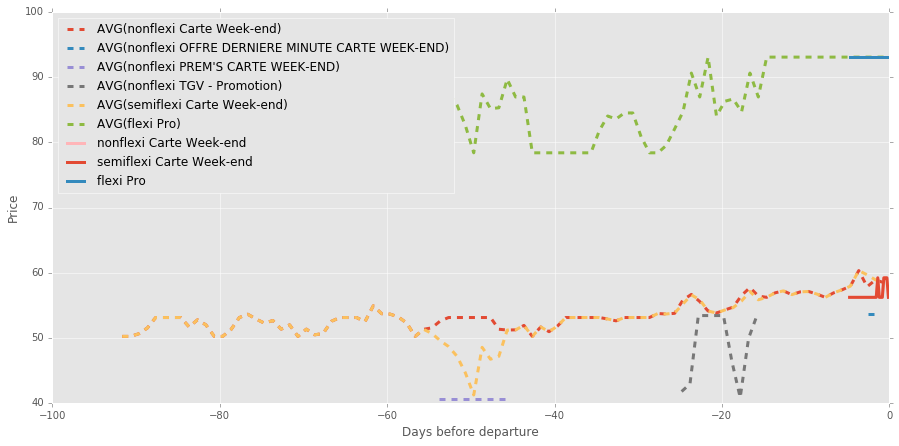

In [40]:
from ipywidgets import widgets
from ipywidgets import interact
from IPython.display import display

trains = results[['departure_station_name', 'departure_date', 'arrival_station_name', 'arrival_date', 'duration', 'stopovers']].drop_duplicates()
trains_labels = trains['departure_station_name'] + ' ' + trains['departure_date'].map(lambda x: x.strftime('%c')) \
                + ' --> ' \
                + trains['arrival_station_name'] + ' ' + trains['arrival_date'].map(lambda x: x.strftime('%c')) \
                + ' (' + trains['duration'].map(lambda x: str(x)) + ', ' + trains['stopovers'] + ')'
    
interact(draw_prices,
    travel_class=widgets.ToggleButtons(
        description="Travel class:",
        value="economy",
        options=list(set(results['travel_class']))
    ),
    train=widgets.Select(
        width=900,
        description="Trains:",
        options=list(zip(trains_labels, trains_labels.index))
    )
)
None